## Comparing Models

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, roc_auc_score

sns.set()
plt.rcParams["figure.figsize"] = (10, 8)
SEED = 42

train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")

train = train_.copy()
test = test_.copy()

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [4]:
num_features = set([c for c in train.columns if train[c].dtype != "object"])
cat_features = set([c for c in train.columns if c not in num_features])
print("Numerical Features: {}\nCategorical Features: {}".format(num_features, cat_features))

Numerical Features: {'SibSp', 'Pclass', 'Parch', 'Survived', 'PassengerId', 'Fare', 'Age'}
Categorical Features: {'Embarked', 'Name', 'Ticket', 'Sex', 'Cabin'}


In [9]:
def replace_rare_titles(df):
    title = df["Title"]
    if title in ["Capt", "Col", "Don", "Jonkheer", "Major", "Sir", "Rev"]:
        return "Mr"
    elif title in ["Mme", "th", "Lady", "Dona"]:
        return 'Mrs'
    elif title in ["Mlle", "Ms"]:
        return 'Miss'
    elif title =='Dr':
        if df['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [10]:
def substrings_in_string(big_string, substrings):
    if pd.isna(big_string):
        return "Unknown"
    for substring in substrings:
        if big_string.find(substring) != -1:
            if substring == "T":
                return "A"
            else:
                return substring

In [5]:
def engineer_numerical_features(df):
    temp = df.copy()
    
    # temp["Age"].fillna(temp["Age"].mean(), inplace=True)
    mean = temp["Age"].mean()
    std = temp["Age"].std()
    is_null = temp["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size=is_null)
    ages = temp["Age"].copy()
    ages[np.isnan(ages)] = rand_age
    temp["Age"] = ages
    temp["Age"] = temp["Age"].astype(int)

    temp.loc[temp["Age"] <= 18, "Age"] = 0
    temp.loc[(temp["Age"] > 18) & (temp["Age"] <= 23), "Age"] = 1
    temp.loc[(temp["Age"] > 23) & (temp["Age"] <= 28), "Age"] = 2
    temp.loc[(temp["Age"] > 28) & (temp["Age"] <= 34), "Age"] = 3
    temp.loc[(temp["Age"] > 34) & (temp["Age"] <= 44), "Age"] = 4
    temp.loc[(temp["Age"] > 44), "Age"] = 5

    #temp["Fare"].fillna(0, inplace=True)
    mean = temp["Fare"].mean()
    std = temp["Fare"].std()
    is_null = temp["Fare"].isnull().sum()
    rand_fare = np.random.randint(mean - std, mean + std, size=is_null)
    fares = temp["Fare"].copy()
    fares[np.isnan(fares)] = rand_fare
    temp["Fare"] = fares
    
    # Need to fix this binning:

    temp.loc[ temp["Fare"] <= 7.775, "Fare"] = 0
    temp.loc[(temp["Fare"] > 7.775) & (temp["Fare"] <= 8.662), "Fare"] = 1
    temp.loc[(temp["Fare"] > 8.662) & (temp["Fare"] <= 14.454), "Fare"] = 2
    temp.loc[(temp["Fare"] > 14.454) & (temp["Fare"] <= 26), "Fare"] = 3
    temp.loc[(temp["Fare"] > 26) & (temp["Fare"] <= 52.369), "Fare"] = 4
    temp.loc[ temp["Fare"] > 52.369, "Fare"] = 5
    temp["Fare"] = temp["Fare"].astype(int)
    
    family_size = temp["SibSp"] + temp["Parch"]
    temp["FamilySize"] = family_size
    
    fare_per_person = temp["Fare"] / (temp["FamilySize"] + 1)
    temp["FarePerPerson"] = fare_per_person
    
    age_class = temp["Age"] * temp["Pclass"]
    temp["AgeClass"] = age_class
    
    return temp

In [7]:
def engineer_categorical_features(df):
    temp = df.copy()
    
    temp["Embarked"].fillna(temp["Embarked"].mode()[0], inplace=True)
    
    titles = temp["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0]
    temp["Title"] = titles
    temp["Title"] = temp.apply(replace_rare_titles, axis=1)
    
    #deck = temp["Cabin"].map(lambda x: substrings_in_string(x, cabin_list))
    temp["Cabin"] = temp["Cabin"].fillna("U0")
    deck = temp["Cabin"].map(lambda x: x[0])
    temp["Deck"] = deck
    decks = {"A": 1, "T": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    temp["Deck"] = temp["Deck"].map(decks)
    temp["Deck"] = temp["Deck"].astype(int)
    
#     genders = {"male": 0, "female": 1}
#     temp["Sex"] = temp["Sex"].map(genders)
    
#     ports = {"S": 0, "C": 1, "Q": 2}
#     temp["Embarked"] = temp["Embarked"].map(ports)
    
    one_hot_cols = ["Title", "Sex", "Embarked"]
    
    for o in one_hot_cols:
        dummies = pd.get_dummies(temp[o], prefix=o)
        temp = pd.concat([temp, dummies], axis=1)
    
    temp.drop(columns=list(cat_features) + ["Title", "Sex", "Embarked", "PassengerId"], inplace=True)
    
    return temp

In [11]:
train_z = engineer_numerical_features(train_)
test_z = engineer_numerical_features(test_)
train_z = engineer_categorical_features(train_z)
test_z = engineer_categorical_features(test_z)

In [15]:
X = train_z.copy()
y = X.pop("Survived")

In [17]:
kfold = StratifiedKFold(n_splits=10)

classifiers = []
classifiers.append(SVC(random_state=SEED))
classifiers.append(DecisionTreeClassifier(random_state=SEED))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=SEED),random_state=SEED,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=SEED))
classifiers.append(ExtraTreesClassifier(random_state=SEED))
classifiers.append(GradientBoostingClassifier(random_state=SEED))
classifiers.append(MLPClassifier(random_state=SEED))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = SEED))
classifiers.append(LinearDiscriminantAnalysis())

In [18]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y = y, scoring = "accuracy", cv = kfold, n_jobs=2))

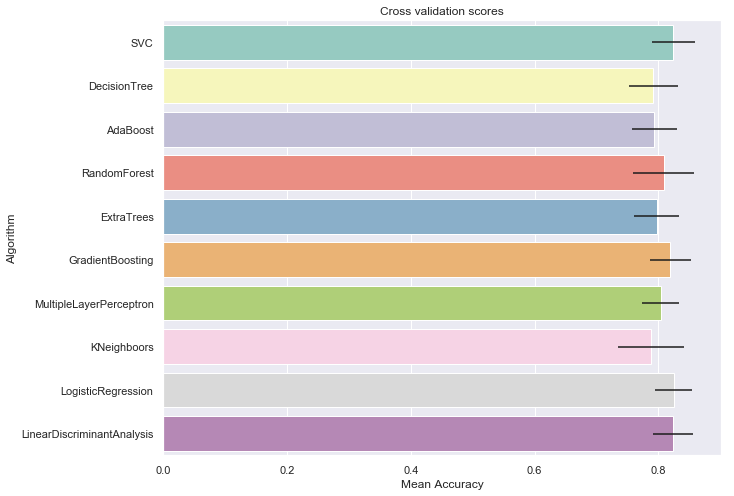

In [19]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [23]:
cv_res.sort_values(by="CrossValMeans", ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
8,0.824978,0.029868,LogisticRegression
0,0.823854,0.034505,SVC
9,0.823817,0.032805,LinearDiscriminantAnalysis
5,0.819360,0.033207,GradientBoosting
3,0.808249,0.049415,RandomForest
6,0.803654,0.029902,MultipleLayerPerceptron
4,0.797000,0.035870,ExtraTrees
2,0.793629,0.036903,AdaBoost
1,0.791332,0.039617,DecisionTree
7,0.788036,0.053254,KNeighboors
